In [10]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io
import glob
import albumentations as A
import random


# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN 
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn import stats_utils

import Monuseg_dist

%matplotlib inline 
# Comment out to reload imported modules if they change
%load_ext autoreload
%autoreload 2

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

MONUSEG_DIR = os.path.join(ROOT_DIR, "datasets\\Monuseg_dist")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [12]:
# Load dataset - 
subset = "val"
dataset_dir = os.path.join(MONUSEG_DIR, subset)
image_dir = os.path.join(dataset_dir, "tissue_images")
image_ids = os.listdir(image_dir)
print("Found {} images in {}".format(len(image_ids), image_dir))


dataset = Monuseg_dist.MonusegDISTDataset()
#dataset_val = Kumar.KumarDataset()
dataset.add_class(source = "Monuseg", class_id =  1, class_name = "nucleus")
#dataset_val.add_class(source = "Kumar", class_id =  1, class_name = "nucleus")

# Fill with the samples
i = 0
for _id in image_ids:
    name,_ = os.path.splitext(_id)
    if i <= len(image_ids):
        dataset.add_image(source = "Monuseg",
                                image_id = name,
                                path = os.path.join(image_dir, _id))
    #else:
        #dataset_val.add_image(source = "Kumar",
        #                      image_id = name,
        #                      path = os.path.join(image_dir,_id))
    i+=1    

    

#dataset_val.prepare()
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Found 14 images in C:\Users\User\GitHub\Mask_RCNN_Thesis\datasets\Monuseg_dist\val\tissue_images
Image Count: 14
Class Count: 2
  0. BG                                                
  1. nucleus                                           


In [13]:
DEVICE = "/gpu:0"
TEST_MODE = "inference"
config = Monuseg_dist.MonusegDIST_H_InferenceConfig()

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
weights_path = r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img220210703T1151\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img2_0050.h5"

print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)
model_dir = os.path.split(weights_path)[0]

Loading weights  C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img220210703T1151\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img2_0050.h5
Re-starting from epoch 50


In [5]:
Monuseg_dist.calc_and_save_detect(model,dataset,model_dir)

TCGA-2Z-A9J9-01A-01-TS1
Running detection...
Found 673 instances
Saving...
TCGA-44-2665-01B-06-BS6
Running detection...
Found 884 instances
Saving...
TCGA-69-7764-01A-01-TS1
Running detection...
Found 584 instances
Saving...
TCGA-A6-6782-01A-01-BS1
Running detection...
Found 522 instances
Saving...
TCGA-AC-A2FO-01A-01-TS1
Running detection...
Found 625 instances
Saving...
TCGA-AO-A0J2-01A-01-BSA
Running detection...
Found 446 instances
Saving...
TCGA-CU-A0YN-01A-02-BSB
Running detection...
Found 827 instances
Saving...
TCGA-EJ-A46H-01A-03-TSC
Running detection...
Found 561 instances
Saving...
TCGA-FG-A4MU-01B-01-TS1
Running detection...
Found 499 instances
Saving...
TCGA-GL-6846-01A-01-BS1
Running detection...
Found 409 instances
Saving...
TCGA-HC-7209-01A-01-TS1
Running detection...
Found 380 instances
Saving...
TCGA-HT-8564-01Z-00-DX1
Running detection...
Found 282 instances
Saving...
TCGA-IZ-8196-01A-01-BS1
Running detection...
Found 631 instances
Saving...
TCGA-ZF-A9R5-01A-01-TS1
R

In [6]:
pred_mask_flat_dict = {}
detection_dir = os.path.join(model_dir, "Detections")
for _id in dataset.image_ids:
    n = dataset.image_info[_id]["id"]
    m = np.load(os.path.join(detection_dir, n + "_label.npy"))
    print("Loaded: {}, Detections: {}".format(n, np.max(m)))
    pred_mask_flat_dict[n] = m
    

Loaded: TCGA-2Z-A9J9-01A-01-TS1, Detections: 673
Loaded: TCGA-44-2665-01B-06-BS6, Detections: 884
Loaded: TCGA-69-7764-01A-01-TS1, Detections: 584
Loaded: TCGA-A6-6782-01A-01-BS1, Detections: 522
Loaded: TCGA-AC-A2FO-01A-01-TS1, Detections: 625
Loaded: TCGA-AO-A0J2-01A-01-BSA, Detections: 446
Loaded: TCGA-CU-A0YN-01A-02-BSB, Detections: 827
Loaded: TCGA-EJ-A46H-01A-03-TSC, Detections: 561
Loaded: TCGA-FG-A4MU-01B-01-TS1, Detections: 499
Loaded: TCGA-GL-6846-01A-01-BS1, Detections: 409
Loaded: TCGA-HC-7209-01A-01-TS1, Detections: 380
Loaded: TCGA-HT-8564-01Z-00-DX1, Detections: 282
Loaded: TCGA-IZ-8196-01A-01-BS1, Detections: 631
Loaded: TCGA-ZF-A9R5-01A-01-TS1, Detections: 538


In [7]:
gt_mask_flat_dict = {}
for _id in dataset.image_ids:   
    info = dataset.image_info[_id]
    n = info["id"]
    m = dataset.load_labelled_mask(_id)
    print("Loaded: {}, Detections: {}".format(n, np.max(m)))
    gt_mask_flat_dict[n] = m


Loaded: TCGA-2Z-A9J9-01A-01-TS1, Detections: 575
Loaded: TCGA-44-2665-01B-06-BS6, Detections: 818
Loaded: TCGA-69-7764-01A-01-TS1, Detections: 441
Loaded: TCGA-A6-6782-01A-01-BS1, Detections: 441
Loaded: TCGA-AC-A2FO-01A-01-TS1, Detections: 521
Loaded: TCGA-AO-A0J2-01A-01-BSA, Detections: 356
Loaded: TCGA-CU-A0YN-01A-02-BSB, Detections: 677
Loaded: TCGA-EJ-A46H-01A-03-TSC, Detections: 466
Loaded: TCGA-FG-A4MU-01B-01-TS1, Detections: 465
Loaded: TCGA-GL-6846-01A-01-BS1, Detections: 355
Loaded: TCGA-HC-7209-01A-01-TS1, Detections: 325
Loaded: TCGA-HT-8564-01Z-00-DX1, Detections: 249
Loaded: TCGA-IZ-8196-01A-01-BS1, Detections: 533
Loaded: TCGA-ZF-A9R5-01A-01-TS1, Detections: 475


In [8]:
# Set up to txt
save_path = os.path.join(model_dir, "stats.txt")
file = open(save_path, "a") 
file.write("NAME\tAJI\tPQ\tDQ\tSQ\n")
print("Logging to {}".format(save_path))
avg_aji = 0
avg_pq = 0
avg_dice1 = 0
avg_dice2 = 0

for n in pred_mask_flat_dict.keys():
    
    print("Running calculations on: {}".format(n))
    
    pred_remap = stats_utils.remap_label(pred_mask_flat_dict[n])
    gt_remap = stats_utils.remap_label(gt_mask_flat_dict[n])
    
    aji = stats_utils.get_fast_aji(gt_remap, pred_remap)
    pq = stats_utils.get_fast_pq(gt_remap, pred_remap)
    dice1 = stats_utils.get_dice_1(gt_remap, pred_remap)
    dice2 = stats_utils.get_fast_dice_2(gt_remap, pred_remap)

    
    avg_aji += aji
    avg_pq += pq[0][2]
    avg_dice1 += dice1
    avg_dice2 += dice2
    
    print("AJI: {}\tPQ:{}".format(aji, pq[0][2]))
#   Write the results in a txt:
    file.write(n + "\t" + str(aji) + "\t" + str(pq[0][2]) + "\t" + str(pq[0][0]) + "\t" + str(pq[0][1]) +  
               "\t" + str(dice1) + "\t" + str(dice2) + "\n")

avg_aji = avg_aji/len(pred_mask_flat_dict.keys())   
avg_pq = avg_pq/len(pred_mask_flat_dict.keys())
avg_dice1 = avg_dice1/len(pred_mask_flat_dict.keys())
avg_dice2 = avg_dice1/len(pred_mask_flat_dict.keys())
print("Mean AJI: " + str(avg_aji) + " Mean PQ: " + str(avg_pq))
file.write("Mean AJI: " + str(avg_aji) + " Mean PQ: " + str(avg_pq))
file.close()

Logging to C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img220210703T1151\stats.txt
Running calculations on: TCGA-2Z-A9J9-01A-01-TS1
AJI: 0.5541808220165629	PQ:0.5469384399352768
Running calculations on: TCGA-44-2665-01B-06-BS6
AJI: 0.6523957181761804	PQ:0.6740675001645897
Running calculations on: TCGA-69-7764-01A-01-TS1
AJI: 0.6145808201116635	PQ:0.6183868037206715
Running calculations on: TCGA-A6-6782-01A-01-BS1
AJI: 0.560158956505355	PQ:0.5696642180551061
Running calculations on: TCGA-AC-A2FO-01A-01-TS1
AJI: 0.5622277009431843	PQ:0.5587043645318208
Running calculations on: TCGA-AO-A0J2-01A-01-BSA
AJI: 0.5534361125413457	PQ:0.5251407445321958
Running calculations on: TCGA-CU-A0YN-01A-02-BSB
AJI: 0.5702510160692751	PQ:0.6122307718251538
Running calculations on: TCGA-EJ-A46H-01A-03-TSC
AJI: 0.5868723921894894	PQ:0.6022960076475962
Running calculations on: TCGA-FG-A4MU-01B-01-TS1
AJI: 0.6463256098493538	PQ:0.6206396853284347
Running calculations on: TCGA-G

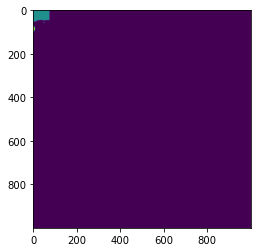

In [9]:
plt.imshow(pred_mask_flat_dict[n])

In [9]:
detection_dir = os.path.join(model_dir)#, "Detections")
pred_mask_flat_dict = {}
for _id in dataset.image_ids:
    n = dataset.image_info[_id]["id"]
    sc = np.load(os.path.join(detection_dir, n + "_scores.npy"))
    avg = np.mean(sc)
    m = np.load(os.path.join(detection_dir, n + "_masks.npz"))["arr_0"] > 0.7
    
    n_m = m[:,:,sc > 0.90]
    f = utils.flatten_mask(n_m)
    pred_mask_flat_dict[n] = f
    print("Loaded: {}, Mean: {}, Detections: {}, Filtered: {}".format(n, avg, len(sc), n_m.shape[-1]))


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\GitHub\\Mask_RCNN_Thesis\\logs\\monuseg_dist_gt_imagenet_1x120210630T2014\\TCGA-2Z-A9J9-01A-01-TS1_scores.npy'

(1000, 1000, 553)


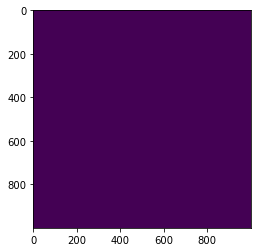

In [30]:
print(n_m.shape)
f = utils.flatten_mask(n_m)
plt.imshow(f)

In [14]:
print(pred_mask_flat_dict)

{'TCGA-2Z-A9J9-01A-01-TS1': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32), 'TCGA-44-2665-01B-06-BS6': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32), 'TCGA-69-7764-01A-01-TS1': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32), 'TCGA-A6-6782-01A-01-BS1': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32), 'TCGA-AC-A2

## TTA

In [11]:
seed = 0
for c in "MoNuSeg":
    #print(c)
    seed += ord(c)
random.seed(seed)

In [6]:
augmented = aug(image = rgb_image, dist = dist)
final = np.zeros(orig_image.shape, dtype = np.uint8)
final[:,:,0:3] =  augmented['image']
final[:,:,3] =  augmented['dist']

final2 = np.zeros(orig_image.shape, dtype = np.uint8)
final2[:,:,0:3] =  augmented['image']
final2[:,:,3] =  augmented['dist']

print(np.all(final == final2))

NameError: name 'aug' is not defined

In [7]:
avg_aji = 0
avg_pq = 0
avg_dice1 = 0
avg_dice2 = 0
pred_mask_flat_dict = {}

save_path = os.path.join(model_dir, "TTA.txt")

file = open(save_path, "a") 
file.write("NAME\tAJI\tPQ\tDQ\tSQ\n")
print("Logging to {}".format(save_path))


augmentations = []
augmentations.append(A.Compose([A.HorizontalFlip(always_apply=True)], additional_targets={'dist': 'mask', 'Hch':'mask'}))
augmentations.append(A.Compose([A.VerticalFlip(always_apply=True)], additional_targets={'dist': 'mask', 'Hch':'mask'}))
augmentations.append(A.Compose([A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, always_apply=True)], additional_targets={'dist': 'mask', 'Hch':'mask'}))

for _id in dataset.image_ids:
    n = dataset.image_info[_id]["id"]
    orig_image = dataset.load_image(_id, source = "UNET")

    image_list = []
    image_list.append(orig_image)
    dist = orig_image[:,:,3]
    rgb_image = orig_image[:,:,0:3]
    hch = orig_image[:,:,4]

    for aug in augmentations:
        augmented = aug(image = rgb_image, dist = dist, Hch = hch)
        final = np.zeros(orig_image.shape, dtype = np.uint8)
        final[:,:,0:3] =  augmented['image']
        final[:,:,3] =  augmented['dist']
        final[:,:,4] = augmented['Hch']
        image_list.append(final.copy())

    results = []
    for image in image_list:   
        #ensemble_mask,scores,boxes = Monuseg_dist.get_ensemble_prediction(model_list, image, config, device='/cpu:0')
        #r = {}
        #r["rois"] = boxes
        #r["masks"] = ensemble_mask
        #r["scores"] = scores
        r = model.detect([image], verbose = 0, binarize = False)[0]
        r["masks"] = (r["masks"] / np.max(r["masks"])) * 255
        r["masks"] = r["masks"].astype(np.uint8)
        n_mask = r["scores"].shape[0]
        results.append(r)

    # Merge the results: Put everything back into one image space - reverse flips
    for i in [1,2]:
        aug = augmentations[i-1]
        # Albumentations wants the masks as int8 for fliplr to work, for odd reasons
        augmented = aug(image = image_list[i], mask = results[i]["masks"].astype(np.int8))
        image_list[i] = augmented["image"]
        results[i]["masks"] = augmented["mask"].astype(np.uint8)
        results[i]["rois"] = utils.extract_bboxes(results[i]["masks"])        

    # Can probably be optimized
    _all_masks = []
    for r in results:
        _all_masks.append(r["masks"])

    _all_masks = np.concatenate(_all_masks, axis = -1)
    mask = utils.mask_merge2(_all_masks)
    
    pred_flat = utils.flatten_mask(mask)
    pred_mask_flat_dict[n] = pred_flat

    print("Running calculations on: {}".format(n))
    pred_remap = stats_utils.remap_label(pred_mask_flat_dict[n])
    gt_remap = stats_utils.remap_label(gt_mask_flat_dict[n])

    aji = stats_utils.get_fast_aji(gt_remap, pred_remap)
    pq = stats_utils.get_fast_pq(gt_remap, pred_remap)
    dice1 = stats_utils.get_dice_1(gt_remap, pred_remap)
    dice2 = stats_utils.get_fast_dice_2(gt_remap, pred_remap)

    
    avg_aji += aji
    avg_pq += pq[0][2]
    avg_dice1 += dice1
    avg_dice2 += dice2
    print("AJI: {}\tPQ: {}".format(aji, pq[0][2]))
    # Write the results in a txt:
    file.write(n + "\t" + str(aji) + "\t" + str(pq[0][2]) + "\t" + str(pq[0][0]) + "\t" + str(pq[0][1]) +
               "\t" + str(dice1) + "\t" + str(dice2) + "\n")
    
avg_pq = avg_pq/len(pred_mask_flat_dict.keys())
avg_aji = avg_aji/len(pred_mask_flat_dict.keys())
avg_dice1 = avg_dice1/len(pred_mask_flat_dict.keys())
avg_dice2 = avg_dice2/len(pred_mask_flat_dict.keys())
print("AVERAGE:" + "\t" + str(avg_aji) + "\t" + str(avg_pq) + "\t" + str(avg_dice1) + "\t" + str(avg_dice2) + "\n")

file.write("AVERAGE:" + "\t" + str(avg_aji) + "\t" + str(avg_pq) + "\t" + str(avg_dice1) + "\t" + str(avg_dice2) + "\n")
file.close()      

Logging to C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_imagenet_1x1_tissue_images20210701T0916\TTA.txt
Running calculations on: TCGA-2Z-A9J9-01A-01-TS1
AJI: 0.5728825684147327	PQ: 0.5641520215005648
Running calculations on: TCGA-44-2665-01B-06-BS6
AJI: 0.6612329338517915	PQ: 0.6861611945633628
Running calculations on: TCGA-69-7764-01A-01-TS1
AJI: 0.6207870866265022	PQ: 0.6279541321137433
Running calculations on: TCGA-A6-6782-01A-01-BS1
AJI: 0.5609346181028391	PQ: 0.5778370638481681
Running calculations on: TCGA-AC-A2FO-01A-01-TS1
AJI: 0.5549374730487279	PQ: 0.5567216363798002
Running calculations on: TCGA-AO-A0J2-01A-01-BSA
AJI: 0.5561259037592015	PQ: 0.5432616147265269
Running calculations on: TCGA-CU-A0YN-01A-02-BSB
AJI: 0.5846361727788448	PQ: 0.6191092759434743
Running calculations on: TCGA-EJ-A46H-01A-03-TSC
AJI: 0.6044681234849252	PQ: 0.6211841615724574
Running calculations on: TCGA-FG-A4MU-01B-01-TS1
AJI: 0.6432942839496795	PQ: 0.620420245601011
Running calculation

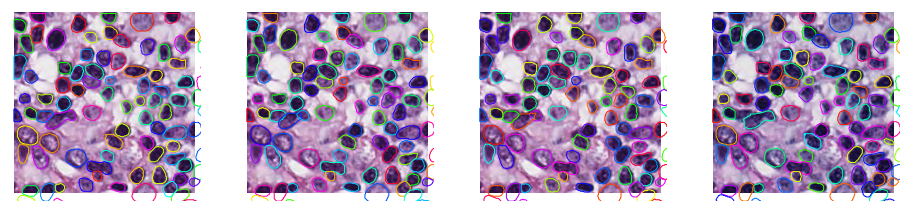

In [10]:
fig, axs = plt.subplots(1,4, figsize=(16, 16))
i = 0
#display_instances(image, boxes, masks, class_ids, class_names,use_captions)
for ax in np.ravel(axs):
        visualize.display_instances(image_list[i][0:256,0:256,0:3], results[i]["rois"], results[i]["masks"]>0.7*255, results[i]["class_ids"],
                                dataset.class_names, show_bbox=False, show_mask=False, use_captions = False, ax = ax, figsize=(16,16))
        i+=1

## Ensemble

In [14]:
path_list = [
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img020210701T1809\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img0_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img120210701T1627\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img1_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img220210703T1151\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img2_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img320210701T1259\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img3_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img420210701T1145\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img4_0050.h5",
]

model_list = []
for weights_path in path_list:
    with tf.device(DEVICE):
        m = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                                  config=config)
    m.load_weights(weights_path, by_name = True)
    m.curr_dir = os.path.split(weights_path)[0]
    print("Added model at: " +  weights_path)
    model_list.append(m)
    
#detection_dir_list = []
#for model in model_list:
#    detection_dir = os.path.join(model.curr_dir)
#    Monuseg_dist.calc_and_save_detect(model, dataset, detection_dir) 
#    detection_dir_list.append(detection_dir)

Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img020210701T1809\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img0_0050.h5
Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img120210701T1627\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img1_0050.h5
Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img220210703T1151\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img2_0050.h5
Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img320210701T1259\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img3_0050.h5
Re-starting from epoch 50
Added model at: C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_5fold_coco_dist_h_tissue_img420210701T1145\mask_rcnn_monuseg_5fold_coco_dist_h_tissue_img4_0050.h5


In [15]:
avg_aji = 0
avg_pq = 0
avg_dice1 = 0
avg_dice2 = 0

pred_mask_flat_dict = {}
save_path = r"D:\Users\User\Documents\BB\Ensemble Predictions\TISSUE_IMG\COCO"
TXT_path = os.path.join(save_path, "Ensemble.txt")

file = open(TXT_path, "a") 
file.write("NAME\tAJI\tPQ\tDQ\tSQ\n")
print("Logging to {}".format(save_path))




for image_id in dataset.image_ids:
    n = dataset.image_info[image_id]["id"] 
    
    all_masks = []
    for model in model_list:
        detection_dir = os.path.join(model.curr_dir, "Detections")
        masks = np.load(os.path.join(detection_dir, n + "_masks.npz"))["arr_0"]
        masks = masks / masks.max() * 255
        masks = masks.astype(np.uint8)
        all_masks.append(masks)
    
    all_masks = np.concatenate(all_masks, axis = -1)
    print(all_masks.shape, all_masks.dtype)
 
    merged_mask = utils.mask_merge2(all_masks)
    np.savez_compressed(os.path.join(save_path, n + ".npz"), masks = merged_mask)
    
    pred_flat = utils.flatten_mask(merged_mask)
    pred_mask_flat_dict[n] = pred_flat

    print("Running calculations on: {}".format(n))
    pred_remap = stats_utils.remap_label(pred_mask_flat_dict[n])
    gt_remap = stats_utils.remap_label(gt_mask_flat_dict[n])

    aji = stats_utils.get_fast_aji(gt_remap, pred_remap)
    pq = stats_utils.get_fast_pq(gt_remap, pred_remap)
    dice1 = stats_utils.get_dice_1(gt_remap, pred_remap)
    dice2 = stats_utils.get_fast_dice_2(gt_remap, pred_remap)

    
    avg_aji += aji
    avg_pq += pq[0][2]
    avg_dice1 += dice1
    avg_dice2 += dice2
    print("AJI: {}\tPQ: {}".format(aji, pq[0][2]))
    # Write the results in a txt:
    file.write(n + "\t" + str(aji) + "\t" + str(pq[0][2]) + "\t" + str(pq[0][0]) + "\t" + str(pq[0][1]) +
               "\t" + str(dice1) + "\t" + str(dice2) + "\n")
    
avg_pq = avg_pq/len(pred_mask_flat_dict.keys())
avg_aji = avg_aji/len(pred_mask_flat_dict.keys())
avg_dice1 = avg_dice1/len(pred_mask_flat_dict.keys())
avg_dice2 = avg_dice2/len(pred_mask_flat_dict.keys())
print("AVERAGE:" + "\t" + str(avg_aji) + "\t" + str(avg_pq) + "\t" + str(avg_dice1) + "\t" + str(avg_dice2) + "\n")

file.write("AVERAGE:" + "\t" + str(avg_aji) + "\t" + str(avg_pq) + "\t" + str(avg_dice1) + "\t" + str(avg_dice2) + "\n")
file.close()


Logging to D:\Users\User\Documents\BB\Ensemble Predictions\TISSUE_IMG\COCO
(1000, 1000, 3419) uint8
Running calculations on: TCGA-2Z-A9J9-01A-01-TS1
AJI: 0.5593684031737558	PQ: 0.5449073495811919
(1000, 1000, 4489) uint8
Running calculations on: TCGA-44-2665-01B-06-BS6
AJI: 0.660827186512118	PQ: 0.6742773577163009
(1000, 1000, 3003) uint8
Running calculations on: TCGA-69-7764-01A-01-TS1
AJI: 0.6251552488215203	PQ: 0.6133228272641321
(1000, 1000, 2628) uint8
Running calculations on: TCGA-A6-6782-01A-01-BS1
AJI: 0.5707103563952434	PQ: 0.5642941686982685
(1000, 1000, 3188) uint8
Running calculations on: TCGA-AC-A2FO-01A-01-TS1
AJI: 0.563673883683279	PQ: 0.5538076349301064
(1000, 1000, 2320) uint8
Running calculations on: TCGA-AO-A0J2-01A-01-BSA
AJI: 0.5589101680564043	PQ: 0.5187226729757699
(1000, 1000, 4228) uint8
Running calculations on: TCGA-CU-A0YN-01A-02-BSB
AJI: 0.5783445919714264	PQ: 0.6080216651574947
(1000, 1000, 2800) uint8
Running calculations on: TCGA-EJ-A46H-01A-03-TSC
AJI: 0

(1000, 1000, 2746) uint8


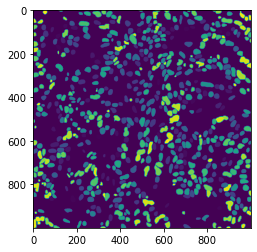

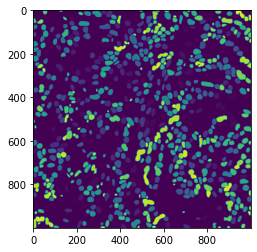

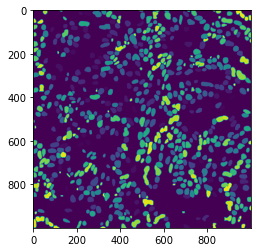

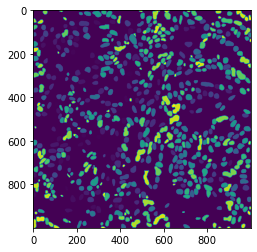

In [15]:
#for image_id in dataset.image_ids:
image_id = 0
n = dataset.image_info[image_id]["id"]

all_masks = []
for model in model_list:
    detection_dir = os.path.join(model.curr_dir, "Detections")
    masks = np.load(os.path.join(detection_dir, n + "_masks.npz"))["arr_0"]
    masks = masks / masks.max() * 255
    masks = masks.astype(np.uint8)
    plt.figure()
    plt.imshow(utils.flatten_mask(masks > 255*0.7))
    all_masks.append(masks)

all_masks = np.concatenate(all_masks, axis = -1)
print(all_masks.shape, all_masks.dtype)

merged_mask = utils.mask_merge2(all_masks)
np.savez_compressed(os.path.join(save_path, n + ".npz"), masks = merged_mask)

pred_flat = utils.flatten_mask(merged_mask)
pred_mask_flat_dict[n] = pred_flat


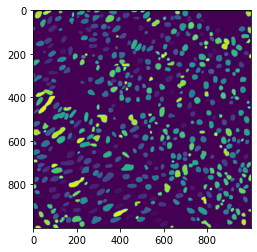

In [16]:
plt.imshow(pred_flat)

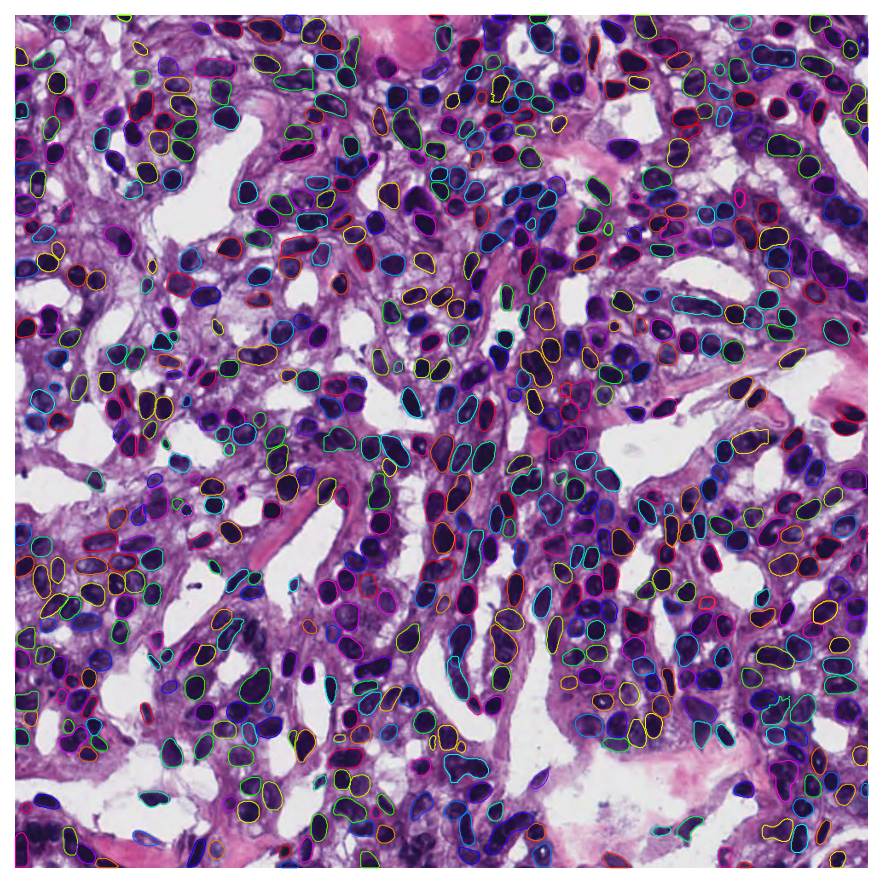

In [18]:
visualize.display_instances(orig_image[:,:,0:3], utils.extract_bboxes(merged_mask), merged_mask, np.ones(merged_mask.shape[-1]), 
                            dataset.class_names, show_bbox = False, show_mask=False, use_captions = False, figsize=(16,16))

In [13]:
for k in pred_mask_flat_dict.keys():
    print(k)
    pred_remap = stats_utils.remap_label(pred_mask_flat_dict[k])
    gt_remap = stats_utils.remap_label(gt_mask_flat_dict[k])
    stats_utils.get_fast_pq(gt_remap, pred_remap)
    print("----")

TCGA-2Z-A9J9-01A-01-TS1
TP: 480
FP: 172
FN: 95
----
TCGA-44-2665-01B-06-BS6
TP: 741
FP: 95
FN: 77
----
TCGA-69-7764-01A-01-TS1
TP: 407
FP: 117
FN: 34
----
TCGA-A6-6782-01A-01-BS1
TP: 362
FP: 102
FN: 79
----
TCGA-AC-A2FO-01A-01-TS1
TP: 446
FP: 144
FN: 75
----
TCGA-AO-A0J2-01A-01-BSA
TP: 296
FP: 128
FN: 60
----
TCGA-CU-A0YN-01A-02-BSB
TP: 612
FP: 164
FN: 65
----
TCGA-EJ-A46H-01A-03-TSC
TP: 418
FP: 87
FN: 48
----
TCGA-FG-A4MU-01B-01-TS1
TP: 392
FP: 77
FN: 73
----
TCGA-GL-6846-01A-01-BS1
TP: 330
FP: 60
FN: 25
----
TCGA-HC-7209-01A-01-TS1
TP: 292
FP: 60
FN: 33
----
TCGA-HT-8564-01Z-00-DX1
TP: 230
FP: 34
FN: 19
----
TCGA-IZ-8196-01A-01-BS1
TP: 506
FP: 82
FN: 27
----
TCGA-ZF-A9R5-01A-01-TS1
TP: 427
FP: 69
FN: 48
----


In [47]:
boxes = []
scores = []
masks = []
detection_dir = r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_pannuke20210523T1039\Detections"
_id = 0
aug_n = ["Norm", "HFlip", "VFlip", "Hue"]
for aug in aug_n:
    n = dataset.image_info[_id]["id"]
    m = np.load(os.path.join(detection_dir, n + aug + "_masks.npz"))["arr_0"] > 0.5
    masks.append(m)
    box = utils.extract_bboxes(m)
    s = np.load(os.path.join(detection_dir, n + aug + "_scores.npy"))
    boxes.append(box)
    scores.append(s)

boxes = np.concatenate(boxes, axis = 0)
scores = np.concatenate(scores, axis = 0)
masks = np.concatenate(masks, axis = -1)
           
gt_mask = dataset.load_mask(_id)[0]


In [53]:
from mrcnn import nms
idx = nms.cpu_soft_nms(boxes, scores ,sigma=0.5,  Nt=0.3,  threshold=0.3, method=1)

f_m = masks[:,:,idx]
print(utils.calc_aji_pq(f_m, gt_mask))

(0.5592288856457197, 0.5282440868795277)


In [51]:
idx = utils.non_max_suppression(boxes, scores, threshold = 0.3)

f_m = masks[:,:,idx]
print(utils.calc_aji_pq(f_m, gt_mask))

(0.563196188268624, 0.5444188223973555)


In [45]:
print(n)

TCGA-2Z-A9J9-01A-01-TS1


In [18]:
pred_mask_flat_dict = {}

#for _id in dataset.image_ids:
_id = 0
info = dataset.image_info[_id]
image = dataset.load_image(_id, source = "UNET")
n = info["id"]
print("Computing Detection for image {}:".format(n))
r = model.detect([image[0:256,0:256,:]], verbose = 0)
print("Found " + str(r[0]["masks"].shape[2]) + " instances")


#pred_mask_flat_dict[n] = utils.flatten_mask(r[0]["masks"]) 
    
print("{} images total".format(len(pred_mask_flat_dict)))


Computing Detection for image TCGA-2Z-A9J9-01A-01-TS1:
Found 2 instances
0 images total


array([[[130,  93, 162],
        [146, 102, 174],
        [165, 111, 184],
        ...,
        [ 50,  27,  80],
        [ 49,  26,  78],
        [ 48,  26,  76]],

       [[133,  91, 156],
        [149, 104, 170],
        [169, 116, 185],
        ...,
        [ 50,  25,  76],
        [ 47,  22,  74],
        [ 45,  21,  72]],

       [[137,  88, 148],
        [155, 106, 167],
        [175, 127, 187],
        ...,
        [ 49,  21,  74],
        [ 46,  19,  71],
        [ 43,  17,  70]],

       ...,

       [[144, 168, 191],
        [160, 184, 208],
        [176, 200, 228],
        ...,
        [135,  86, 143],
        [141,  92, 153],
        [144,  92, 158]],

       [[147, 169, 196],
        [164, 187, 213],
        [183, 205, 231],
        ...,
        [128,  77, 139],
        [142,  89, 155],
        [148,  94, 163]],

       [[166, 126, 167],
        [152, 171, 203],
        [175, 197, 222],
        ...,
        [121,  68, 132],
        [137,  81, 149],
        [143,  88, 156]]

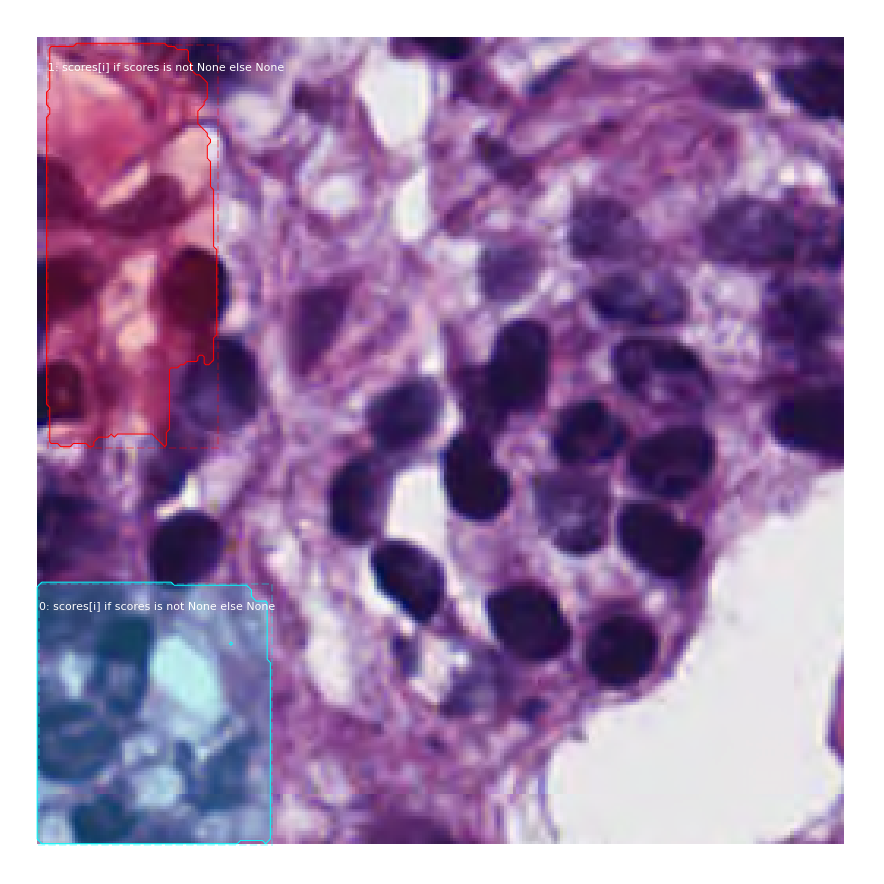

In [21]:
img = image
m = r[0]["masks"]
visualize.display_instances(image[0:256,0:256,0:3], utils.extract_bboxes(m), m, np.ones(m.shape[-1], dtype = int), ["",""])

In [ ]:
gt_mask_flat_dict = {}
for _id in dataset.image_ids:   

    info = dataset.image_info[_id]
    n = info["id"]
    print("Loading masks of {}".format(info["id"]))

    # Read binary masks (all *.pngs in the image_id folder in binary_mask
    gt_mask,_ = dataset.load_mask(_id)
    print("Found " + str(gt_mask.shape[2]) + " instances")
    gt_mask_flat_dict[n] = utils.flatten_mask(gt_mask)


(1000, 1000)


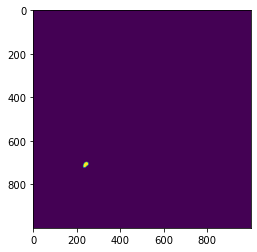

In [24]:
example = np.load(r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_pannuke_macenko_nocoloraug_1x120210627T0929\Detections\TCGA-2Z-A9J9-01A-01-TS1_masks.npz")["arr_0"]
gt_mask = np.load(r"C:\Users\User\GitHub\Mask_RCNN_Thesis\datasets\MoNuSeg_Dist\val\mask_binary\TCGA-2Z-A9J9-01A-01-TS1.npz")["masks"]

example_m = example[:,:,0]
plt.imshow(example_m)
print(example_m.shape)

In [98]:
#image = skimage.io.imread(r"C:\Users\User\GitHub\Mask_RCNN_Thesis\datasets\MoNuSeg_Dist\val\macenko\TCGA-2Z-A9J9-01A-01-TS1.tif")
#masks = np.load(r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_pannuke_macenko_nocoloraug_1x120210627T0929\Detections\TCGA-2Z-A9J9-01A-01-TS1_masks.npz")["arr_0"]
#scores = np.load(r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_pannuke_macenko_nocoloraug_1x120210627T0929\Detections\TCGA-2Z-A9J9-01A-01-TS1_scores.npy")
p = r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_pannuke_macenko_nocoloraug_1x120210627T0929\Detections"


#for _id in dataset.image_ids:
_id = 7
img = dataset.load_image(_id, source = "UNET")
info = dataset.image_info[_id]
n = info["id"]
print(n)
masks = np.load(os.path.join(p, n + "_masks.npz"))["arr_0"]
scores = np.load(os.path.join(p, n + "_scores.npy"))
n_m = masks[:,:, scores > 0.95]
masks = n_m
bboxes = utils.extract_bboxes(masks)
mean = []
c = 0
for i in range(bboxes.shape[0]): 
    b = bboxes[i]
    if b[2] - b[0] > 0 and b[3] - b[1] > 0: 
        instance = img[b[0]:b[2], b[1]:b[3],:]
        mask = masks[b[0]:b[2], b[1]:b[3],i]

        inst_nan = instance.astype(np.float)
        inst_nan[mask == 0] = np.nan
        avg = np.nanmean(inst_nan, axis = (0,1))
        for i in range(3):     
            if np.any(avg[i] < threshs[i][0]) or np.any(avg[i] > threshs[i][1]):
                print(c, "ALARM")
    c+=1
print("---")
    


TCGA-EJ-A46H-01A-03-TSC
15 ALARM
15 ALARM
16 ALARM
16 ALARM
30 ALARM
30 ALARM
30 ALARM
38 ALARM
46 ALARM
46 ALARM
46 ALARM
52 ALARM
54 ALARM
54 ALARM
54 ALARM
64 ALARM
72 ALARM
72 ALARM
72 ALARM
97 ALARM
97 ALARM
103 ALARM
103 ALARM
114 ALARM
125 ALARM
125 ALARM
125 ALARM
136 ALARM
136 ALARM
137 ALARM
137 ALARM
138 ALARM
138 ALARM
138 ALARM
160 ALARM
165 ALARM
165 ALARM
165 ALARM
201 ALARM
201 ALARM
206 ALARM
209 ALARM
209 ALARM
218 ALARM
218 ALARM
224 ALARM
241 ALARM
311 ALARM
311 ALARM
324 ALARM
355 ALARM
355 ALARM
357 ALARM
360 ALARM
360 ALARM
368 ALARM
368 ALARM
390 ALARM
390 ALARM
398 ALARM
398 ALARM
414 ALARM
414 ALARM
431 ALARM
431 ALARM
---


In [123]:
img = dataset.load_image(_id, source = "UNET")

i = 398
b = bboxes[i]
instance = img[b[0]:b[2], b[1]:b[3],:].copy()
mask = masks[b[0]:b[2], b[1]:b[3], i]
instance[mask == 0] = 0
#plt.imshow(instance[:,:,0:3])
inst_nan = instance.astype(np.float)
inst_nan[mask == 0] = np.nan
avg = np.nanmean(inst_nan, axis = (0,1))
print(avg)

[197.46743849 163.74384949 191.65412446  29.60492041 118.89869754]


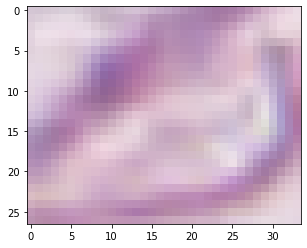

In [124]:
plt.imshow(img[b[0]:b[2], b[1]:b[3],0:3])


In [91]:
print(bboxes[i:i+1])

[[588 719 609 734]]


In [69]:
avg[1] = 12
print(avg)
print(threshs)
for i in range(3):     
    if np.any(avg[i] < threshs[i][0]) or np.any(avg[i] > threshs[i][1]):
        print("A")

[72.15606936 12.         76.86705202]
[[ 50.3253012  194.56731876]
 [ 23.8981289  126.71871412]
 [ 63.21978022 215.48522551]]
A


In [61]:
print(m)

[168.07142857 117.64285714 155.14285714]


In [62]:
c = 0
threshs = [[50.325301204819276, 194.56731875719217],
          [23.8981288981289, 126.7187141216992],
          [63.21978021978022, 215.48522550544322]]
threshs = np.array(threshs)
for m in mean:
    for i in range(3):     
        if np.any(m[i] < threshs[i][0]) or np.any(m[i] > threshs[i][1]):
            print(c, "ALARM")
    c+=1


[902 963 927 986]


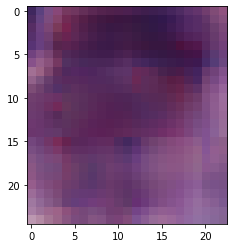

In [58]:
b = bboxes[234]
print(b)
plt.imshow(image[b[0]:b[2], b[1]:b[3],:])

In [31]:
for _id in dataset.image_ids:
    img = dataset.load_image(_id, source = "UNET")
    info = dataset.image_info[_id]
    n = info["id"]
    print(n)
    masks = np.load(os.path.join(p, n + "_masks.npz"))["arr_0"]
    bboxes = utils.extract_bboxes(masks)
    mean = []
    for i in range(bboxes.shape[0]): 
        b = bboxes[i]
        if b[2] - b[0] > 0 and b[3] - b[1] > 0: 
            instance = img[b[0]:b[2], b[1]:b[3],:]
            mask = masks[b[0]:b[2], b[1]:b[3],i]

            inst_nan = instance.astype(np.float)
            inst_nan[mask == 0] = np.nan
            avg = np.nanmean(inst_nan, axis = (0,1))
        mean.append(avg)
    pred_mean_dict[n] = mean.copy()   

In [9]:
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        2000
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            5
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [256 256   5]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [4]:
DEVICE = "/gpu:0"
TEST_MODE = "inference"
config = Monuseg_dist.MonusegDIST_H_InferenceConfig()

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)


model_list_tissue = [
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_imagenet_1x1_tissue_images20210701T0916\mask_rcnn_monuseg_dist_gt_imagenet_1x1_tissue_images_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_imagenet_1x1_pannuke_tissue_images20210701T1036\mask_rcnn_monuseg_dist_gt_imagenet_1x1_pannuke_tissue_images_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_coco_1x120210630T1701\mask_rcnn_monuseg_dist_gt_coco_1x1_0050.h5",
    r"C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_imagenet_only_h_no1x120210701T2213\mask_rcnn_monuseg_dist_gt_imagenet_only_h_no1x1_0050.h5"
]


gt_mask_flat_dict = {}
for _id in dataset.image_ids:   
    info = dataset.image_info[_id]
    n = info["id"]
    m = dataset.load_labelled_mask(_id)
    print("Loaded: {}, Detections: {}".format(n, np.max(m)))
    gt_mask_flat_dict[n] = m

    

for p in model_list_tissue:
    # Load Model, run inferrence, calc scores, done

    model.load_weights(p, by_name=True)
    model_dir = os.path.split(p)[0]

    Monuseg_dist.calc_and_save_detect(model,dataset,model_dir)
    pred_mask_flat_dict = {}
    detection_dir = os.path.join(model_dir, "Detections")
    for _id in dataset.image_ids:
        n = dataset.image_info[_id]["id"]
        m = np.load(os.path.join(detection_dir, n + "_label.npy"))
        print("Loaded: {}, Detections: {}".format(n, np.max(m)))
        pred_mask_flat_dict[n] = m
        
        
# Set up to txt
    save_path = os.path.join(model_dir, "stats.txt")
    file = open(save_path, "a") 
    file.write("NAME\tAJI\tPQ\tDQ\tSQ\n")
    print("Logging to {}".format(save_path))
    avg_aji = 0
    avg_pq = 0
    avg_dice1 = 0
    avg_dice2 = 0

    for n in pred_mask_flat_dict.keys():

        print("Running calculations on: {}".format(n))

        pred_remap = stats_utils.remap_label(pred_mask_flat_dict[n])
        gt_remap = stats_utils.remap_label(gt_mask_flat_dict[n])

        aji = stats_utils.get_fast_aji(gt_remap, pred_remap)
        pq = stats_utils.get_fast_pq(gt_remap, pred_remap)
        dice1 = stats_utils.get_dice_1(gt_remap, pred_remap)
        dice2 = stats_utils.get_fast_dice_2(gt_remap, pred_remap)


        avg_aji += aji
        avg_pq += pq[0][2]
        avg_dice1 += dice1
        avg_dice2 += dice2

        print("AJI: {}\tPQ:{}".format(aji, pq[0][2]))
    #   Write the results in a txt:
        file.write(n + "\t" + str(aji) + "\t" + str(pq[0][2]) + "\t" + str(pq[0][0]) + "\t" + str(pq[0][1]) +  
                   "\t" + str(dice1) + "\t" + str(dice2) + "\n")

    avg_aji = avg_aji/len(pred_mask_flat_dict.keys())   
    avg_pq = avg_pq/len(pred_mask_flat_dict.keys())
    avg_dice1 = avg_dice1/len(pred_mask_flat_dict.keys())
    avg_dice2 = avg_dice1/len(pred_mask_flat_dict.keys())
    print("Mean AJI: " + str(avg_aji) + " Mean PQ: " + str(avg_pq))
    file.write("Mean AJI: " + str(avg_aji) + " Mean PQ: " + str(avg_pq))
    file.close()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loaded: TCGA-2Z-A9J9-01A-01-TS1, Detections: 575
Loaded: TCGA-44-2665-01B-06-BS6, Detections: 818
Loaded: TCGA-69-7764-01A-01-TS1, Detections: 441
Loaded: TCGA-A6-6782-01A-01-BS1, Detections: 441
Loaded: TCGA-AC-A2FO-01A-01-TS1, Detections: 521
Loaded: TCGA-AO-A0J2-01A-01-BSA, Detections: 356
Loaded: TCGA-CU-A0YN-01A-02-BSB, Detections: 677
Loaded: TCGA-EJ-A46H-01A-03-TSC, Detections: 466
Loaded: TCGA-FG-A4MU-01B-01-TS1, Detections: 465
Loaded: TCGA-GL-6846-01A-01-BS1, Detections: 355
Loaded: TCGA-HC-7209-01A-01-TS1, Detections: 325
Loaded: TCGA-HT-8564-01Z-00-DX1, Detections: 249
Loaded: TCGA-IZ-8196-01A-01-BS1, Detections: 533
Loaded: TCGA-ZF-A9R5-01A-01-TS1, Detections: 475
Re-starting from epoch 50
TCGA-2Z-A9J9-01A-01-TS1
Running detection...
Found 660 instan

AJI: 0.590716778156819	PQ:0.581398502696556
Running calculations on: TCGA-44-2665-01B-06-BS6
AJI: 0.6754561892848124	PQ:0.6817543658658094
Running calculations on: TCGA-69-7764-01A-01-TS1
AJI: 0.6404980531624613	PQ:0.6302878751076132
Running calculations on: TCGA-A6-6782-01A-01-BS1
AJI: 0.5856530256749355	PQ:0.5754984422802051
Running calculations on: TCGA-AC-A2FO-01A-01-TS1
AJI: 0.5840210547796391	PQ:0.5689589605809611
Running calculations on: TCGA-AO-A0J2-01A-01-BSA
AJI: 0.582203519151084	PQ:0.5403193632113418
Running calculations on: TCGA-CU-A0YN-01A-02-BSB
AJI: 0.6054971510143841	PQ:0.6303802250655323
Running calculations on: TCGA-EJ-A46H-01A-03-TSC
AJI: 0.6378327678532975	PQ:0.6385965026779392
Running calculations on: TCGA-FG-A4MU-01B-01-TS1
AJI: 0.6718579189021006	PQ:0.638705237410189
Running calculations on: TCGA-GL-6846-01A-01-BS1
AJI: 0.6796017079332569	PQ:0.6783619841355738
Running calculations on: TCGA-HC-7209-01A-01-TS1
AJI: 0.6605938726393616	PQ:0.6399299508571556
Running 

ValueError: Layer #2 (named "conv1"), weight <tf.Variable 'conv1/kernel:0' shape=(7, 7, 3, 64) dtype=float32_ref> has shape (7, 7, 3, 64), but the saved weight has shape (64, 5, 7, 7).

In [7]:
print(p)

C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_imagenet_1x1_tissue_images20210701T0916\mask_rcnn_monuseg_dist_gt_imagenet_1x1_tissue_images_0050.h5C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_imagenet_1x1_pannuke_tissue_images20210701T1036\mask_rcnn_monuseg_dist_gt_imagenet_1x1_pannuke_tissue_images_0050.h5C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_coco_1x120210630T1701\mask_rcnn_monuseg_dist_gt_coco_1x1_0050.h5C:\Users\User\GitHub\Mask_RCNN_Thesis\logs\monuseg_dist_gt_imagenet_only_h_no1x120210701T2213\mask_rcnn_monuseg_dist_gt_imagenet_only_h_no1x1_0050.h5
